In [1]:
from skimage.io import imread
from skimage import color
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu, gaussian
from skimage.transform import resize
import numpy as np
import os
from natsort import natsorted
from sklearn.preprocessing import MinMaxScaler
from tkinter import Tk
from tkinter.filedialog import askopenfilename
import joblib
import pandas as pd
from skimage import measure
from sklearn.decomposition import PCA
from skimage.metrics import structural_similarity
from numpy import asarray
from sklearn.neighbors import KNeighborsClassifier
from natsort import natsorted
from sklearn import linear_model, tree, ensemble
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from joblib import load, dump
from sklearn import __version__ as sklearn_version

In [2]:
class ECG:
    def getImage(self):
        Tk().withdraw()
        image_path = askopenfilename(title="image.jpg")
        if not image_path:
            raise ValueError("No image selected. Please provide an ECG image.")
        return image_path

    def displayImage(self, image):
        original_image = imread(image)
        plt.imshow(original_image)
        plt.title("Original ECG Image")
        plt.axis('off')
        plt.show()

    def GrayImgae(self, image):
        image = imread(image)
        image_gray = color.rgb2gray(image)
        image_gray = resize(image_gray, (1572, 2213))
        plt.imshow(image_gray, cmap='gray')
        plt.title("Grayscale ECG Image")
        plt.axis('off')
        plt.show()
        return image_gray

    def DividingLeads(self, image):
        image = imread(image)
        Lead_1 = image[300:600, 150:643]
        Lead_2 = image[300:600, 646:1135]
        Lead_3 = image[300:600, 1140:1625]
        Lead_4 = image[300:600, 1630:2125]
        Lead_5 = image[600:900, 150:643]
        Lead_6 = image[600:900, 646:1135]
        Lead_7 = image[600:900, 1140:1625]
        Lead_8 = image[600:900, 1630:2125]
        Lead_9 = image[900:1200, 150:643]
        Lead_10 = image[900:1200, 646:1135]
        Lead_11 = image[900:1200, 1140:1625]
        Lead_12 = image[900:1200, 1630:2125]
        Lead_13 = image[1250:1480, 150:2125]

        Leads = [Lead_1, Lead_2, Lead_3, Lead_4, Lead_5, Lead_6, Lead_7, Lead_8, Lead_9, Lead_10, Lead_11, Lead_12,
                 Lead_13]
        fig, ax = plt.subplots(4, 3)
        fig.set_size_inches(10, 10)
        x_counter = 0
        y_counter = 0

        for x, y in enumerate(Leads[:len(Leads) - 1]):
            if (x + 1) % 3 == 0:
                ax[x_counter][y_counter].imshow(y)
                ax[x_counter][y_counter].axis('off')
                ax[x_counter][y_counter].set_title("Leads {}".format(x + 1))
                x_counter += 1
                y_counter = 0
            else:
                ax[x_counter][y_counter].imshow(y)
                ax[x_counter][y_counter].axis('off')
                ax[x_counter][y_counter].set_title("Leads {}".format(x + 1))
                y_counter += 1

        fig.savefig('Leads_1-12_figure.png')
        fig1, ax1 = plt.subplots()
        fig1.set_size_inches(10, 10)
        ax1.imshow(Lead_13)
        ax1.set_title("Leads 13")
        ax1.axis('off')
        fig1.savefig('Long_Lead_13_figure.png')

        return Leads

    def PreprocessingLeads(self, Leads):
        fig2, ax2 = plt.subplots(4, 3)
        fig2.set_size_inches(10, 10)
        x_counter = 0
        y_counter = 0

        for x, y in enumerate(Leads[:len(Leads) - 1]):
            grayscale = color.rgb2gray(y)
            blurred_image = gaussian(grayscale, sigma=1)
            global_thresh = threshold_otsu(blurred_image)
            binary_global = blurred_image < global_thresh
            binary_global = resize(binary_global, (300, 450))
            if (x + 1) % 3 == 0:
                ax2[x_counter][y_counter].imshow(binary_global, cmap="gray")
                ax2[x_counter][y_counter].axis('off')
                ax2[x_counter][y_counter].set_title("pre-processed Leads {} image".format(x + 1))
                x_counter += 1
                y_counter = 0
            else:
                ax2[x_counter][y_counter].imshow(binary_global, cmap="gray")
                ax2[x_counter][y_counter].axis('off')
                ax2[x_counter][y_counter].set_title("pre-processed Leads {} image".format(x + 1))
                y_counter += 1
        fig2.savefig('Preprocessed_Leads_1-12_figure.png')

    def SignalExtraction_Scaling(self, Leads):
        fig4, ax4 = plt.subplots(4, 3)
        x_counter = 0
        y_counter = 0
        for x, y in enumerate(Leads[:len(Leads) - 1]):
            grayscale = color.rgb2gray(y)
            blurred_image = gaussian(grayscale, sigma=0.7)
            global_thresh = threshold_otsu(blurred_image)
            binary_global = blurred_image < global_thresh
            contours = measure.find_contours(binary_global, 0.8)
            contours_shape = sorted([x.shape for x in contours])[::-1][0:1]
            for contour in contours:
                if contour.shape in contours_shape:
                    test = resize(contour, (255, 2))
            if (x + 1) % 3 == 0:
                ax4[x_counter][y_counter].invert_yaxis()
                ax4[x_counter][y_counter].plot(test[:, 1], test[:, 0], linewidth=1, color='black')
                ax4[x_counter][y_counter].axis('image')
                ax4[x_counter][y_counter].set_title("Contour {} image".format(x + 1))
                x_counter += 1
                y_counter = 0
            else:
                ax4[x_counter][y_counter].invert_yaxis()
                ax4[x_counter][y_counter].plot(test[:, 1], test[:, 0], linewidth=1, color='black')
                ax4[x_counter][y_counter].axis('image')
                ax4[x_counter][y_counter].set_title("Contour {} image".format(x + 1))
                y_counter += 1

            lead_no = x
            scaler = MinMaxScaler()
            fit_transform_data = scaler.fit_transform(test)
            Normalized_Scaled = pd.DataFrame(fit_transform_data[:, 0], columns=['X'])
            Normalized_Scaled = Normalized_Scaled.T
            if (os.path.isfile('scaled_data_1D_{lead_no}.csv'.format(lead_no=lead_no + 1))):
                Normalized_Scaled.to_csv('Scaled_1DLead_{lead_no}.csv'.format(lead_no=lead_no + 1), mode='a',
                                         index=False)
            else:
                Normalized_Scaled.to_csv('Scaled_1DLead_{lead_no}.csv'.format(lead_no=lead_no + 1), index=False)

        fig4.savefig('Contour_Leads_1-12_figure.png')

    def CombineConvert1Dsignal(self):
        test_final = pd.read_csv('Scaled_1DLead_1.csv')
        location = os.getcwd()
        for files in natsorted(os.listdir(location)):
            if files.endswith(".csv"):
                if files != 'Scaled_1DLead_1.csv':
                    df = pd.read_csv('{}'.format(files))
                    test_final = pd.concat([test_final, df], axis=1, ignore_index=True)

        return test_final

    def DimensionalReduciton(self, test_final):
        pca_loaded_model = joblib.load('PCA_ECG (1).pkl')
        result = pca_loaded_model.transform(test_final)
        final_df = pd.DataFrame(result)
        return final_df

    def ModelLoad_predict(self, final_df):
        # Load the model
        loaded_model = load('Heart_Disease_Prediction_using_ECG (4).pkl')

        # Resave the model (if successfully loaded) to ensure compatibility
        if sklearn_version != "1.0.1":
            dump(loaded_model, 'Updated_Heart_Disease_Model.pkl')
        result = loaded_model.predict(final_df)
        if result[0] == 1:
            return "You ECG corresponds to Myocardial Infarction"
        elif result[0] == 0:
            return "You ECG corresponds to Abnormal Heartbeat"
        elif result[0] == 2:
            return "Your ECG is Normal"
        else:
            return "You ECG corresponds to History of Myocardial Infarction"

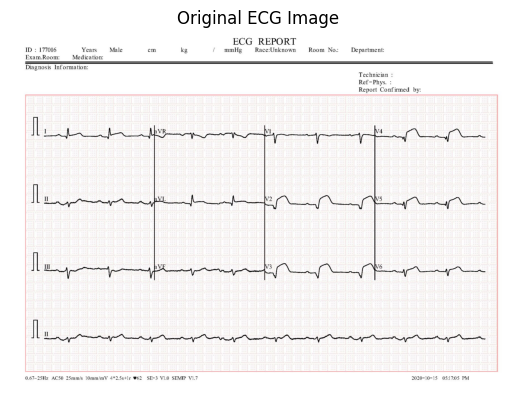

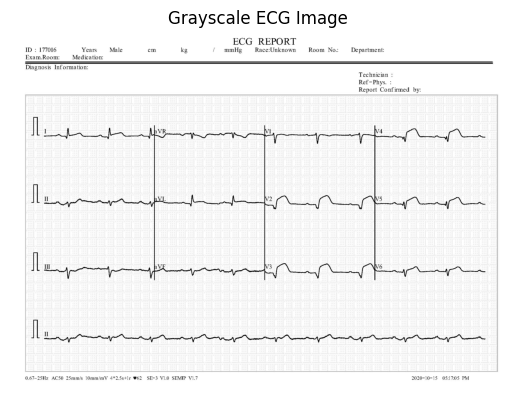

c:\Python311\Lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.0.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.0.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator KNeighborsClassifier from version 1.0.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For 

ValueError: node array from the pickle has an incompatible dtype:
- expected: {'names': ['left_child', 'right_child', 'feature', 'threshold', 'impurity', 'n_node_samples', 'weighted_n_node_samples', 'missing_go_to_left'], 'formats': ['<i8', '<i8', '<i8', '<f8', '<f8', '<i8', '<f8', 'u1'], 'offsets': [0, 8, 16, 24, 32, 40, 48, 56], 'itemsize': 64}
- got     : [('left_child', '<i8'), ('right_child', '<i8'), ('feature', '<i8'), ('threshold', '<f8'), ('impurity', '<f8'), ('n_node_samples', '<i8'), ('weighted_n_node_samples', '<f8')]

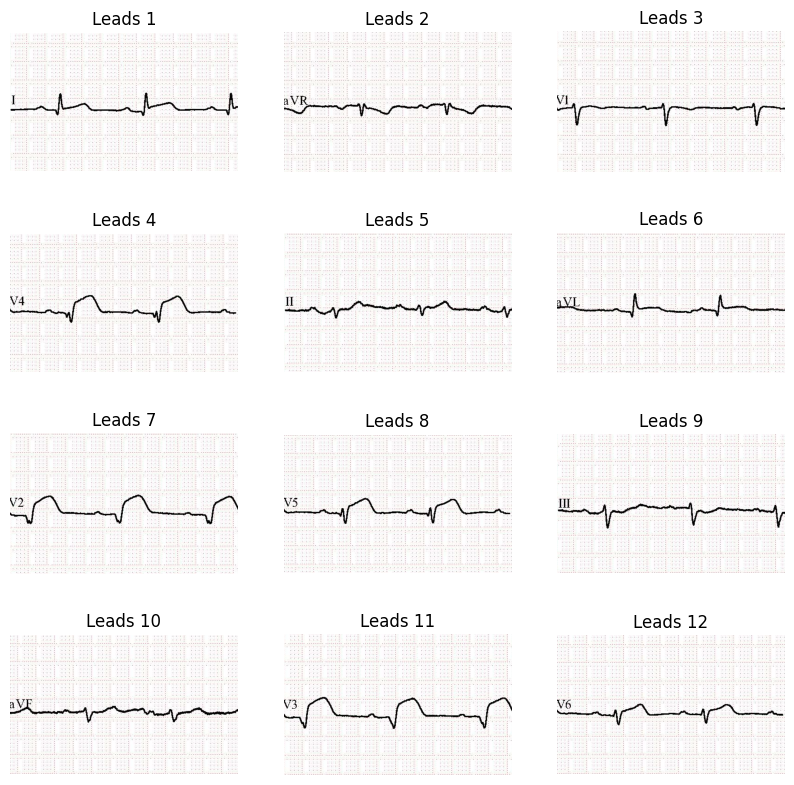

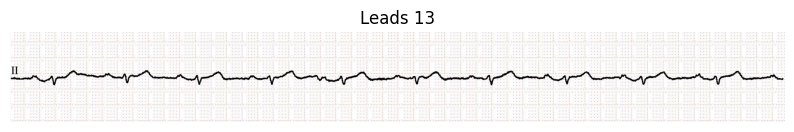

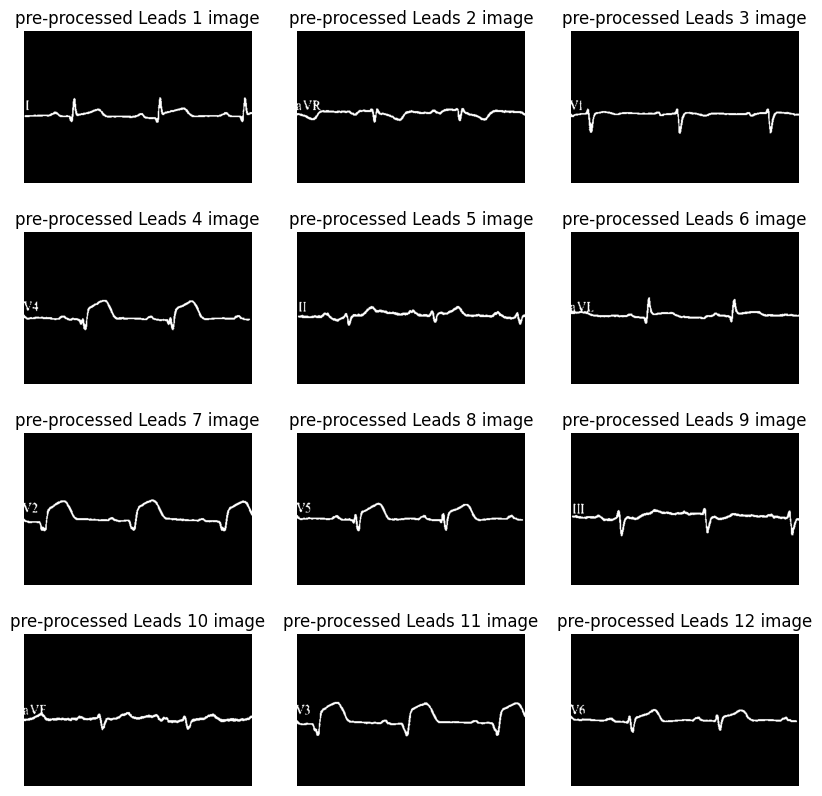

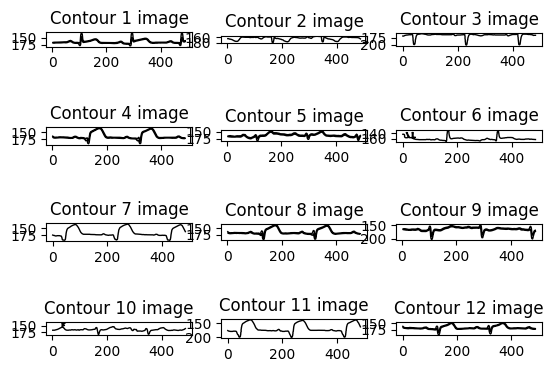

In [3]:
if __name__ == "__main__":
    ecg = ECG()
    image_path = ecg.getImage()
    ecg.displayImage(image_path)
    gray_image = ecg.GrayImgae(image_path)
    leads = ecg.DividingLeads(image_path)
    ecg.PreprocessingLeads(leads)
    ecg.SignalExtraction_Scaling(leads)
    final_data = ecg.CombineConvert1Dsignal()
    reduced_data = ecg.DimensionalReduciton(final_data)
    classification_result = ecg.ModelLoad_predict(reduced_data)
    print(classification_result)

In [11]:
import sklearn
print(sklearn.__version__)


1.3.0
